In [ ]:
!pip install pandas_profiling

In [1]:
import pandas as pd
import numpy as np
import re 
#import geopandas as gpd
import pandas as pd
import json
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style="white")
import warnings
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
from pandas_profiling import ProfileReport
import random
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [2]:
budgets_fbi = pd.read_csv('CleanData/Merged_FBI_Budgets_Normalized.csv')
budgets_fbi.head()

,city_merge_name,population,city_population,year,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,educ_elem_sec,social_services,public_welfare,welfare_cash,welfare_vendors,welfare_other,correction,parks_recreation,housing_commdevt
0,"Anchorage, AK",260900,259348,2000,0.005841,0.043473,5523.35,352.61,2426.51,2386.40,0.0,2386.40,195.60,0.0,0.0,0.0,0.0,0.0,213.45,0.0
1,"Anchorage, AK",263588,260816,2001,0.006632,0.043500,4831.29,594.42,2281.82,2251.80,0.0,2251.80,138.03,0.0,0.0,0.0,0.0,0.0,266.67,0.0
2,"Anchorage, AK",267280,264274,2002,0.006439,0.044706,4914.64,708.42,2455.38,2426.06,0.0,2426.06,165.42,0.0,0.0,0.0,0.0,0.0,285.35,0.0
3,"Anchorage, AK",282940,268229,2003,0.006789,0.045483,4463.29,320.32,2590.59,2561.61,0.0,2561.61,176.95,0.0,0.0,0.0,0.0,0.0,121.36,0.0
4,"Anchorage, AK",286671,270568,2004,0.008062,0.038187,5007.39,325.37,2627.83,2599.76,0.0,2599.76,143.11,0.0,0.0,0.0,0.0,0.0,136.75,0.0


### Load the Income Data

In [3]:
income_data= pd.read_csv('CleanData/DPI_Clean.csv')
povertydf = pd.read_csv('CleanData/Demographics.csv')
racedf = pd.read_csv('CleanData/Race.csv')
racedf = racedf[racedf['geographic_area_name'].notnull()]


income_data.loc[income_data.loc[income_data['city'].str.contains('Fort Smith, AR')].index.values,'city'] = 'Ft. Smith, AR'
income_data.loc[income_data.loc[income_data['city'].str.contains('Boise City, ID')].index.values,'city'] = 'Boise, ID'
income_data.loc[income_data.loc[income_data['city'].str.contains('Louisville/Jefferson County, KY')].index.values,'city'] = 'Louisville, KY'

povertydf.loc[povertydf.loc[povertydf['city_name'].str.contains('Fort Smith, AR')].index.values,'city_name'] = 'Ft. Smith, AR'
povertydf.loc[povertydf.loc[povertydf['city_name'].str.contains('Boise City, ID')].index.values,'city_name'] = 'Boise, ID'
povertydf.loc[povertydf.loc[povertydf['city_name'].str.contains('Louisville/Jefferson County, KY')].index.values,'city_name'] = 'Louisville, KY'

racedf.loc[racedf.loc[racedf['geographic_area_name'].str.contains('Fort Smith, AR')].index.values,'geographic_area_name'] = 'Ft. Smith, AR'
racedf.loc[racedf.loc[racedf['geographic_area_name'].str.contains('Boise City, ID')].index.values,'geographic_area_name'] = 'Boise, ID'
racedf.loc[racedf.loc[racedf['geographic_area_name'].str.contains('Louisville/Jefferson County, KY')].index.values,'geographic_area_name'] = 'Louisville, KY'

In [4]:
merged_df = budgets_fbi.merge(income_data,left_on=['city_merge_name','year'],right_on = ['city','Year'],how='inner')
merged_df.city.unique().shape

(119,)

### Lost Cities

In [5]:
for i in budgets_fbi.city_merge_name.unique():
    if i not in merged_df.city.unique():
        print(i)

Oakland, CA
Wilmington, DE
Ft. Lauderdale, FL
St. Petersburg, FL
Ft. Wayne, IN
Gary, IN
Kansas City, KS
St. Paul, MN
Ft. Worth, TX
Norfolk, VA
Tacoma, WA


In [6]:
merged_df2 = merged_df.merge(povertydf,left_on=['city_merge_name','year'],right_on = ['city_name','Year'],how='inner')
merged_df2.city.unique().shape

(118,)

In [7]:
for i in merged_df.city_merge_name.unique():
    if i not in merged_df2.city.unique():
        print(i)

Boise, ID


In [8]:
merged_df3 = merged_df2.merge(racedf,left_on=['city_merge_name','year'],right_on = ['geographic_area_name','Year'],how='inner')
merged_df3 = merged_df3.T.drop_duplicates().T


merged_df3['percent_race_one_race_asian'] =merged_df3['percent_race_one_race_asian'].str.replace('N','0.0')
merged_df3['percent_race_one_race_black_or_african_american'] = merged_df3['percent_race_one_race_black_or_african_american'].str.replace('N','0.0')
merged_df3['percent_race_one_race_native_hawaiian_and_other_pacific_islander'] = merged_df3['percent_race_one_race_native_hawaiian_and_other_pacific_islander'].str.replace('N','0.0')
merged_df3['percent_race_one_race_white'] = merged_df3['percent_race_one_race_white'].str.replace('N','0.0')
merged_df3= merged_df3.drop(columns=['city_population'])
merged_df3.head()

,city_merge_name,population,year,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,...,total_estimate_mean_income_deficit_for_unrelated_individuals_(dollars),total_estimate_age_under_18_years,total_estimate_sex_male,total_estimate_age_65_years_and_over,percent_below_poverty_level_estimate_age_18_to_64_years,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,percent_hispanic_or_latino
0,"Anchorage, AK",313181,2010,0.008129,0.035063,6036.69,433.95,2880.31,2846.29,0.0,...,6609.0,100776,188590,26787,8.6,6.5,4.9,1.7,71.1,6.7
1,"Anchorage, AK",310965,2011,0.007892,0.033020,5815.54,410.66,2787.14,2755.34,0.0,...,6002.0,99826,188626,30084,7.5,6.5,4.3,1.6,70.8,6.9
2,"Anchorage, AK",313529,2012,0.008111,0.036182,5378.15,446.75,2429.79,2398.01,0.0,...,7493.0,99897,194906,31203,7.9,7.4,5.0,1.6,70.3,7.2
3,"Anchorage, AK",314553,2013,0.007938,0.041478,5694.68,454.03,2471.81,2439.77,0.0,...,6788.0,100002,196614,33232,7.2,6.5,4.8,1.7,69.8,7.6
4,"Anchorage, AK",316696,2014,0.008437,0.039514,5735.87,468.50,2456.47,2430.38,0.0,...,6674.0,99732,197075,35819,8.5,7.4,4.5,1.7,69.3,7.9


In [9]:
norm_column = "population_persons"


cols_to_normalize = ["personal_income_thousands_of_dollars",
"total_estimate_educational_attainment_population_25_years_and_over",
"total_estimate_age_18_to_64_years",
"total_estimate_employment_status_civilian_labor_force_16_years_and_over",
"total_estimate_population_for_whom_poverty_status_is_determined",
"total_estimate_age_65_years_and_over",
"total_estimate_sex_female",
"total_estimate_work_experience_population_16_years_and_over",
"total_estimate_age_under_18_years",
"total_estimate_sex_male",
"total_estimate_age_65_years_and_over"]


for i in cols_to_normalize:
    merged_df3[i] = merged_df3[i]/merged_df3["population_persons"]

In [10]:
merged_df3

,city_merge_name,population,year,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,...,total_estimate_mean_income_deficit_for_unrelated_individuals_(dollars),total_estimate_age_under_18_years,total_estimate_sex_male,total_estimate_age_65_years_and_over,percent_below_poverty_level_estimate_age_18_to_64_years,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,percent_hispanic_or_latino
0,"Anchorage, AK",313181,2010,0.008129,0.035063,6036.69,433.95,2880.31,2846.29,0.0,...,6609.0,0.263086,0.492334,0.000000,8.6,6.5,4.9,1.7,71.1,6.7
1,"Anchorage, AK",310965,2011,0.007892,0.033020,5815.54,410.66,2787.14,2755.34,0.0,...,6002.0,0.257335,0.486247,0.000000,7.5,6.5,4.3,1.6,70.8,6.9
2,"Anchorage, AK",313529,2012,0.008111,0.036182,5378.15,446.75,2429.79,2398.01,0.0,...,7493.0,0.254884,0.497295,0.000000,7.9,7.4,5.0,1.6,70.3,7.2
3,"Anchorage, AK",314553,2013,0.007938,0.041478,5694.68,454.03,2471.81,2439.77,0.0,...,6788.0,0.251880,0.495222,0.000000,7.2,6.5,4.8,1.7,69.8,7.6
4,"Anchorage, AK",316696,2014,0.008437,0.039514,5735.87,468.50,2456.47,2430.38,0.0,...,6674.0,0.250585,0.495168,0.000000,8.5,7.4,4.5,1.7,69.3,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,"Cheyenne, WY",95635,2013,0.002070,0.027459,8445.96,339.58,2471.24,2401.25,0.0,...,5944.0,0.236075,0.492952,0.000001,9.7,1.8,3.4,0.0,88.0,14.1
874,"Cheyenne, WY",96236,2014,0.001600,0.024326,8430.56,359.75,2541.09,2481.71,0.0,...,5887.0,0.229789,0.483527,0.000001,11.8,1.0,3.3,0.0,84.9,14.3
875,"Cheyenne, WY",96943,2015,0.001774,0.025819,8849.32,470.45,2767.05,2703.34,0.0,...,5956.0,0.231115,0.487878,0.000001,11.0,1.2,2.5,0.2,88.7,14.5
876,"Cheyenne, WY",97275,2016,0.002519,0.030213,8710.69,504.08,2665.20,2599.29,0.0,...,5882.0,0.226884,0.496746,0.000001,9.8,1.2,2.7,0.4,90.6,14.6


In [11]:
dfoi = merged_df3[merged_df3.year==2017][merged_df3.columns[:9]].head(10)
dfoi 
profile = ProfileReport(dfoi)

In [13]:
def convert_to_numeric(df,col):
    try:
        df[col] = df[col].apply(float)
    except:
        print(col)
    
def convert_name_to_numeric(row):
    return name_dict[row]

def numeric_to_name(row):
    return label_dict[row]
    
    

### Create The Df for clustering

In [18]:
test= merged_df3.copy().dropna()
years= test.year
test = test.drop(columns='population')
test = test.drop(columns="population_persons")

for i in test.columns:
    convert_to_numeric(test,i)
test = test.drop(columns='year')
test

city_merge_name


,city_merge_name,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,educ_elem_sec,social_services,...,total_estimate_mean_income_deficit_for_unrelated_individuals_(dollars),total_estimate_age_under_18_years,total_estimate_sex_male,total_estimate_age_65_years_and_over,percent_below_poverty_level_estimate_age_18_to_64_years,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,percent_hispanic_or_latino
0,"Anchorage, AK",0.008129,0.035063,6036.69,433.95,2880.31,2846.29,0.0,2846.29,103.90,...,6609.0,0.263086,0.492334,1.825603e-07,8.6,6.5,4.9,1.7,71.1,6.7
1,"Anchorage, AK",0.007892,0.033020,5815.54,410.66,2787.14,2755.34,0.0,2755.34,93.42,...,6002.0,0.257335,0.486247,1.999156e-07,7.5,6.5,4.3,1.6,70.8,6.9
2,"Anchorage, AK",0.008111,0.036182,5378.15,446.75,2429.79,2398.01,0.0,2398.01,96.70,...,7493.0,0.254884,0.497295,2.031304e-07,7.9,7.4,5.0,1.6,70.3,7.2
3,"Anchorage, AK",0.007938,0.041478,5694.68,454.03,2471.81,2439.77,0.0,2439.77,128.83,...,6788.0,0.251880,0.495222,2.108275e-07,7.2,6.5,4.8,1.7,69.8,7.6
4,"Anchorage, AK",0.008437,0.039514,5735.87,468.50,2456.47,2430.38,0.0,2430.38,81.63,...,6674.0,0.250585,0.495168,2.261289e-07,8.5,7.4,4.5,1.7,69.3,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,"Cheyenne, WY",0.002070,0.027459,8445.96,339.58,2471.24,2401.25,0.0,2401.25,3678.48,...,5944.0,0.236075,0.492952,1.399698e-06,9.7,1.8,3.4,0.0,88.0,14.1
874,"Cheyenne, WY",0.001600,0.024326,8430.56,359.75,2541.09,2481.71,0.0,2481.71,3337.76,...,5887.0,0.229789,0.483527,1.472203e-06,11.8,1.0,3.3,0.0,84.9,14.3
875,"Cheyenne, WY",0.001774,0.025819,8849.32,470.45,2767.05,2703.34,0.0,2703.34,3448.83,...,5956.0,0.231115,0.487878,1.434651e-06,11.0,1.2,2.5,0.2,88.7,14.5
876,"Cheyenne, WY",0.002519,0.030213,8710.69,504.08,2665.20,2599.29,0.0,2599.29,3753.47,...,5882.0,0.226884,0.496746,1.491359e-06,9.8,1.2,2.7,0.4,90.6,14.6


## Create mappings between names and numerics so we can do clustering

In [19]:
name_dict = {}
label_dict = {}
for i,item in enumerate(merged_df3['city_merge_name'].unique()):
    name_dict[item] = i
    label_dict[i]=item
name_dict

{'Anchorage, AK': 0,
 'Fairbanks, AK': 1,
 'Birmingham, AL': 2,
 'Mobile, AL': 3,
 'Montgomery, AL': 4,
 'Ft. Smith, AR': 5,
 'Little Rock, AR': 6,
 'Phoenix, AZ': 7,
 'Tucson, AZ': 8,
 'Bakersfield, CA': 9,
 'Fresno, CA': 10,
 'Los Angeles, CA': 11,
 'Modesto, CA': 12,
 'Riverside, CA': 13,
 'Sacramento, CA': 14,
 'San Diego, CA': 15,
 'San Francisco, CA': 16,
 'San Jose, CA': 17,
 'Stockton, CA': 18,
 'Colorado Springs, CO': 19,
 'Denver, CO': 20,
 'Bridgeport, CT': 21,
 'Hartford, CT': 22,
 'New Haven, CT': 23,
 'Washington, DC': 24,
 'Dover, DE': 25,
 'Jacksonville, FL': 26,
 'Miami, FL': 27,
 'Orlando, FL': 28,
 'Tallahassee, FL': 29,
 'Tampa, FL': 30,
 'Atlanta, GA': 31,
 'Columbus, GA': 32,
 'Cedar Rapids, IA': 33,
 'Des Moines, IA': 34,
 'Chicago, IL': 35,
 'Indianapolis, IN': 36,
 'Topeka, KS': 37,
 'Wichita, KS': 38,
 'Lexington, KY': 39,
 'Louisville, KY': 40,
 'Baton Rouge, LA': 41,
 'New Orleans, LA': 42,
 'Shreveport, LA': 43,
 'Boston, MA': 44,
 'Springfield, MA': 45,
 '

In [20]:
test['city_merge_name'] = test['city_merge_name'].apply(convert_name_to_numeric)

distortions = [] 
inertias = []
mapping1 = {}
mapping2 = {} 
K = range(1,15) 

X = test.values[:,:]
X = np.nan_to_num(X)
#Normalize data
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-1.68559998,  2.2067123 ,  0.51518854, ...,  5.29925911,
        -0.30709506, -0.52068741],
       [-1.68559998,  2.07108669,  0.26610533, ...,  4.95647412,
        -0.33126239, -0.50839514],
       [-1.68559998,  2.19641162,  0.65161738, ...,  4.95647412,
        -0.37154127, -0.48995673],
       ...,
       [ 1.74821823, -1.42999978, -0.6118429 , ...,  0.15748424,
         1.11072164, -0.04128883],
       [ 1.74821823, -1.00366611, -0.07612501, ...,  0.84305422,
         1.2637814 , -0.0351427 ],
       [ 1.74821823, -0.75473302, -0.29314318, ..., -0.52808574,
         1.16711208, -0.02285043]])

1 : 5.70018975096815
2 : 5.3917719469910335
3 : 5.207612323944026
4 : 5.022429564912141
5 : 4.864104706107142
6 : 4.7160956958143085
7 : 4.563308706876765
8 : 4.4511338473194355
9 : 4.369382748059937
10 : 4.257811667476735
11 : 4.171261437428003
12 : 4.103724396440776
13 : 4.031793365680211
14 : 3.9816486636897275


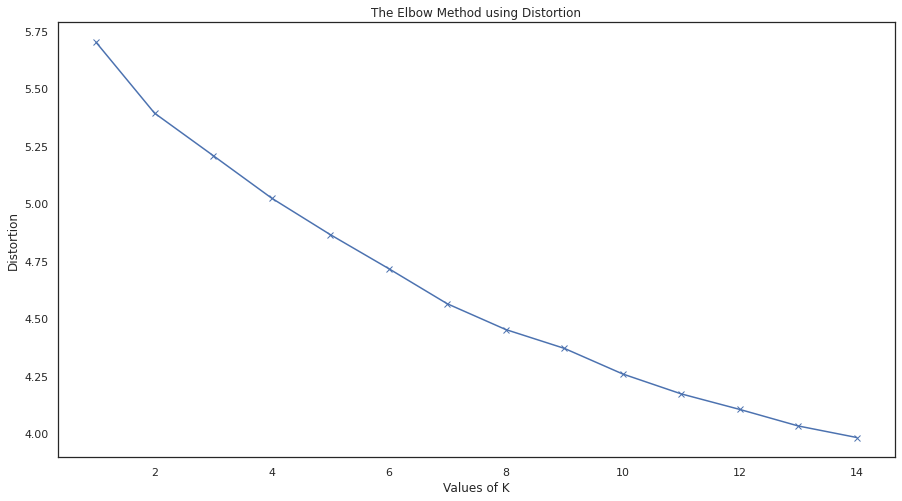

1 : 31239.00000000004
2 : 27775.765436503872
3 : 24608.998403928646
4 : 22668.826596544495
5 : 20987.14412850473
6 : 19750.12211686777
7 : 18577.77829891294
8 : 17625.475588994334
9 : 16803.09281369035
10 : 15985.943205844624
11 : 15365.41474354404
12 : 14776.039639946468
13 : 14227.262647177593
14 : 13803.619425688772


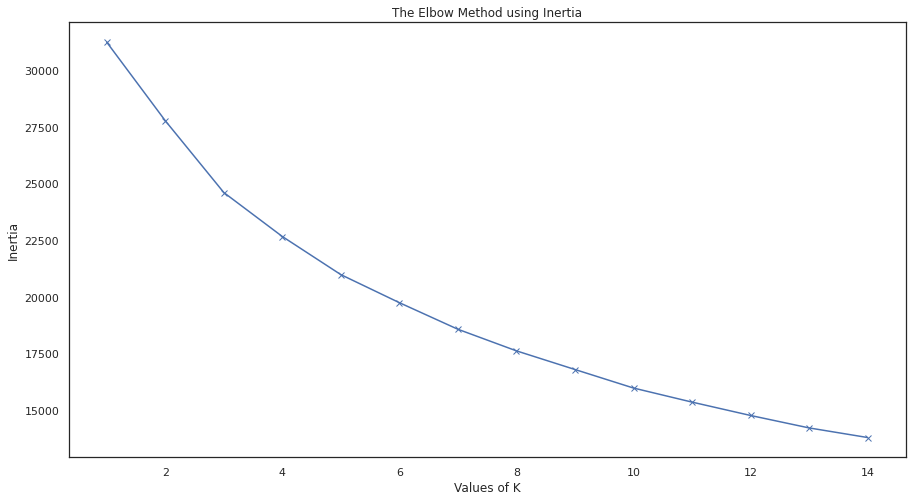

In [15]:
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(init="k-means++", n_clusters=k, n_init=50)
    kmeanModel.fit(cluster_dataset)     
      
    distortions.append(sum(np.min(cdist(cluster_dataset, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cluster_dataset.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(cluster_dataset, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cluster_dataset.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
test['city_merge_name'] = test['city_merge_name'].apply(numeric_to_name)   
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 
        
# Make Plot 1

plt.figure(figsize=(15,8))
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 
    
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 
    
# Make Plot 2

plt.figure(figsize=(15,8))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [22]:
test['city_merge_name'] = test['city_merge_name'].apply(numeric_to_name)   
num_clusters = 6
test['city_merge_name'] = test['city_merge_name'].apply(convert_name_to_numeric)

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan")
k_means.fit(cluster_dataset)
labels = k_means.labels_

test['city_merge_name'] = test['city_merge_name'].apply(numeric_to_name)
test["Labels"] = labels
test['Year'] = years

In [24]:
modes = test.groupby(['city_merge_name','Labels']).count().reset_index().sort_values(by='violent_crime')
top_labels = modes[['city_merge_name','Labels','violent_crime']].groupby('city_merge_name').head(1)[['city_merge_name','Labels']]
labels = top_labels.sort_values('Labels')
summary = labels.groupby('Labels').head(10).rename(columns={"city_merge_name":"City","Labels":"Group"}).reset_index().drop(columns="index")
summary

,City,Group
0,"Buffalo, NY",0
1,"Minneapolis, MN",0
2,"Anchorage, AK",0
3,"Syracuse, NY",0
4,"Richmond, VA",0
5,"Hartford, CT",0
6,"Seattle, WA",0
7,"Baltimore, MD",0
8,"Cleveland, OH",0
9,"Springfield, MA",0


In [39]:
test[['city_merge_name','Labels']].groupby('city_merge_name').mean().head(15)

,Labels
city_merge_name,
"Akron, OH",3.571429
"Albuquerque, NM",1.000000
"Anchorage, AK",0.000000
"Atlanta, GA",0.875000
"Austin, TX",2.875000
"Bakersfield, CA",5.000000
"Baltimore, MD",0.000000
"Baton Rouge, LA",1.000000
"Billings, MT",4.000000


In [31]:
modes['city_merge_name'].unique().shape

(118,)

In [40]:
test[test.Year==2017]

,city_merge_name,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,educ_elem_sec,social_services,...,total_estimate_sex_male,total_estimate_age_65_years_and_over,percent_below_poverty_level_estimate_age_18_to_64_years,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,percent_hispanic_or_latino,Labels,Year
7,"Anchorage, AK",0.011628,0.054414,5694.71,445.15,2366.46,2339.58,0.00,2339.58,76.03,...,0.494777,2.616849e-07,9.4,8.3,4.1,2.0,67.5,8.0,0,2017
15,"Fairbanks, AK",0.006082,0.046639,5423.24,207.75,2191.84,2133.62,0.00,2133.62,41.98,...,0.491738,9.557020e-07,6.7,3.0,4.6,0.1,75.5,8.1,4,2017
28,"Mobile, AL",0.006190,0.045552,4735.96,336.27,1348.10,1298.20,0.00,1298.20,352.03,...,0.449907,3.453245e-07,17.2,1.8,35.6,0.0,58.9,2.9,1,2017
35,"Montgomery, AL",0.004854,0.035318,5467.05,280.76,1375.48,1360.19,0.00,1360.19,1780.93,...,0.451162,3.857258e-07,16.6,2.1,45.0,0.0,50.3,3.0,1,2017
43,"Ft. Smith, AR",0.005063,0.029493,4747.42,207.73,1940.98,1901.30,0.00,1901.30,16.60,...,0.546299,7.126185e-07,17.8,2.5,3.7,0.0,75.7,10.1,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,"Madison, WI",0.002286,0.018260,4930.46,367.77,1782.19,1708.38,0.00,1708.38,564.77,...,0.486810,2.108337e-07,12.4,5.1,4.3,0.1,85.9,5.8,4,2017
854,"Milwaukee, WI",0.006805,0.025459,6435.59,587.49,1960.23,1913.30,0.00,1913.30,530.51,...,0.479160,9.453728e-08,12.6,3.8,16.6,0.0,72.3,10.8,1,2017
861,"Huntington, WV",0.003069,0.021935,3785.71,319.82,1472.17,1413.55,64.08,1349.47,48.32,...,0.474006,4.957477e-07,21.5,0.5,2.6,0.0,94.3,0.8,1,2017
869,"Casper, WY",0.002195,0.026152,5749.63,349.50,3038.71,3037.61,0.00,3037.61,58.28,...,0.486769,1.710312e-06,11.4,0.0,0.0,0.0,0.0,8.4,0,2017


In [111]:
first = test
first[first.Group==5]['city_merge_name'].unique()

array(['Anchorage, AK', 'Los Angeles, CA', 'Sacramento, CA',
       'San Diego, CA', 'San Francisco, CA', 'San Jose, CA', 'Denver, CO',
       'Bridgeport, CT', 'Hartford, CT', 'New Haven, CT', 'Atlanta, GA',
       'Chicago, IL', 'Boston, MA', 'Baltimore, MD', 'Minneapolis, MN',
       'Buffalo, NY', 'New York, NY', 'Rochester, NY', 'Syracuse, NY',
       'Cleveland, OH', 'Richmond, VA', 'Seattle, WA', 'Casper, WY'],
      dtype=object)

In [41]:
def apply_labels(row):
    item = labels['Labels'][labels.city_merge_name==row].values[0]
    return item

In [42]:
test['Group']=test['city_merge_name'].apply(apply_labels)

In [23]:
res= test.groupby('Group').median().reset_index()
res.sort_values(by='violent_crime',ascending=False)

,Group,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,educ_elem_sec,social_services,...,total_estimate_age_under_18_years,total_estimate_sex_male,total_estimate_age_65_years_and_over,percent_below_poverty_level_estimate_age_18_to_64_years,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,percent_hispanic_or_latino,Labels
4,4,0.005101,0.033705,5733.980,345.480,1904.090,1889.520,0.00,1889.52,973.460,...,0.276068,0.485466,1.400744e-07,17.60,4.30,4.80,0.2,74.80,50.0,4
1,1,0.005036,0.034320,5890.535,394.630,1516.105,1471.305,0.00,1468.69,240.635,...,0.230122,0.475828,1.385385e-07,15.05,2.50,17.70,0.0,72.40,7.8,1
2,2,0.004044,0.029888,5159.220,279.370,1653.290,1617.550,0.00,1570.46,348.490,...,0.228785,0.444764,1.425983e-07,14.00,2.60,19.50,0.0,74.60,8.6,1
5,5,0.003523,0.024961,7810.225,461.795,2263.640,2215.240,0.00,2215.24,567.430,...,0.224109,0.479284,6.184825e-08,11.45,5.35,8.35,0.0,71.45,10.6,5
3,3,0.003276,0.021403,20394.970,945.235,4327.615,4202.810,270.63,3933.48,6336.805,...,0.229669,0.478330,1.827708e-08,7.75,9.70,25.35,0.1,55.70,14.9,3
0,0,0.003168,0.028689,5175.370,302.680,1664.160,1623.770,0.00,1608.81,194.490,...,0.228533,0.481444,2.289555e-07,12.30,2.20,4.30,0.0,85.70,5.6,0


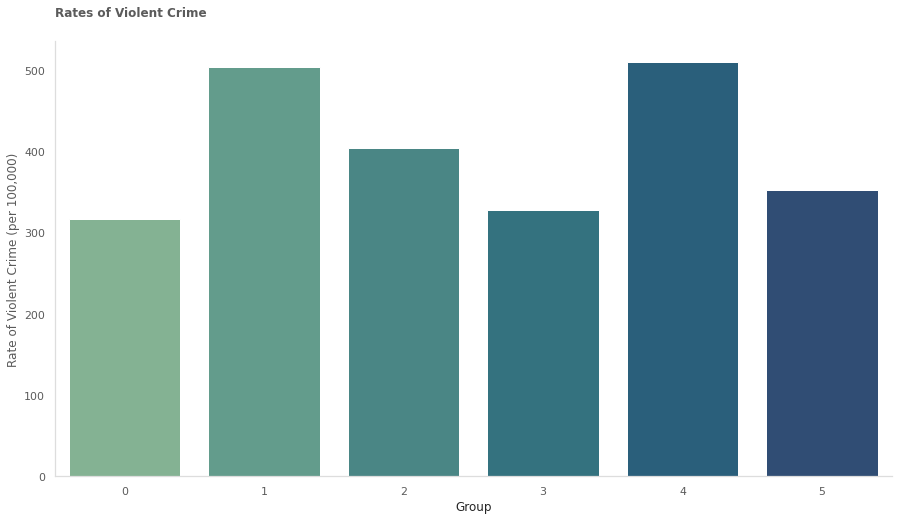

In [24]:
crime = res.copy()
crime[["violent_crime","property_crime"]] = crime[["violent_crime","property_crime"]]*(10**5)
plt.figure(figsize=(15,8))
ax = sns.barplot(data=crime,x='Group',y='violent_crime',palette="crest")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Rates of Violent Crime', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Rate of Violent Crime (per 100,000)',color='#5B5B5B')

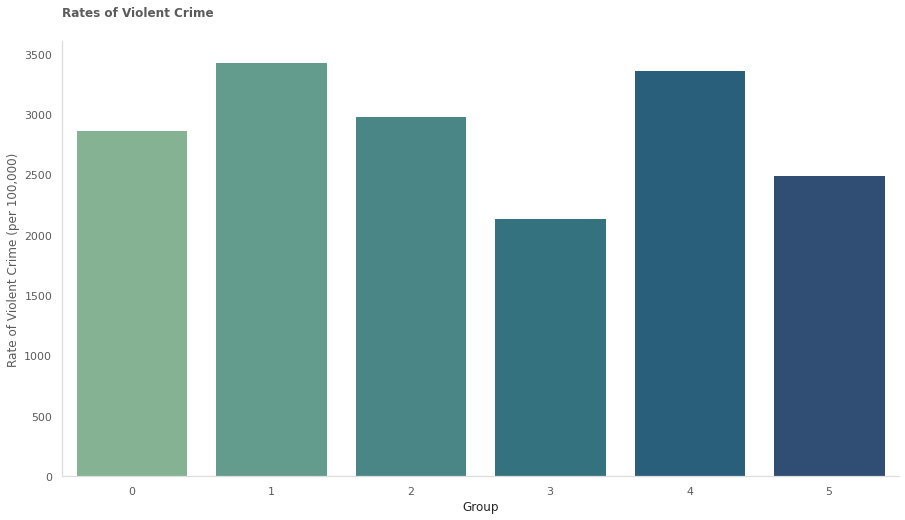

In [25]:
crime = res.copy()
crime[["violent_crime","property_crime"]] = crime[["violent_crime","property_crime"]]*(10**5)
plt.figure(figsize=(15,8))
ax = sns.barplot(data=crime,x='Group',y='property_crime',palette="crest")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Rates of Violent Crime', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Rate of Violent Crime (per 100,000)',color='#5B5B5B')

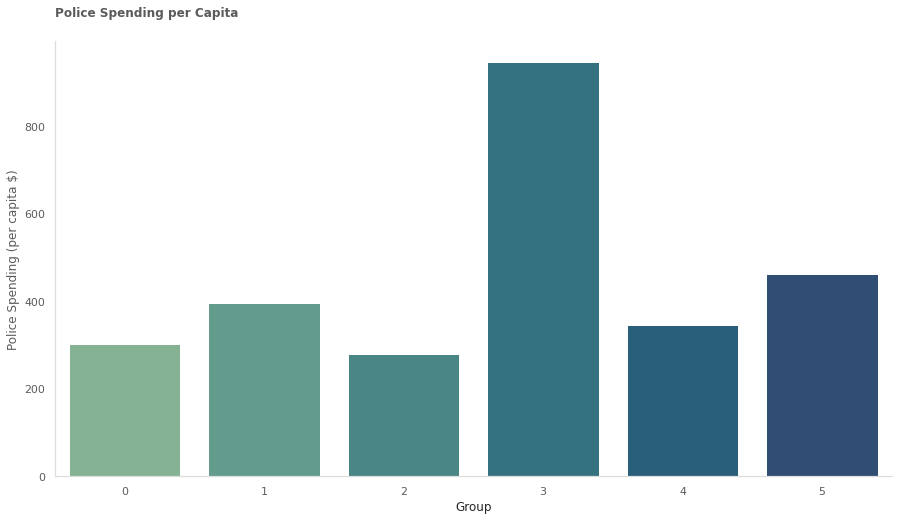

In [26]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=res,x='Group',y='police',palette="crest")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Police Spending per Capita', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Police Spending (per capita $)',color='#5B5B5B')

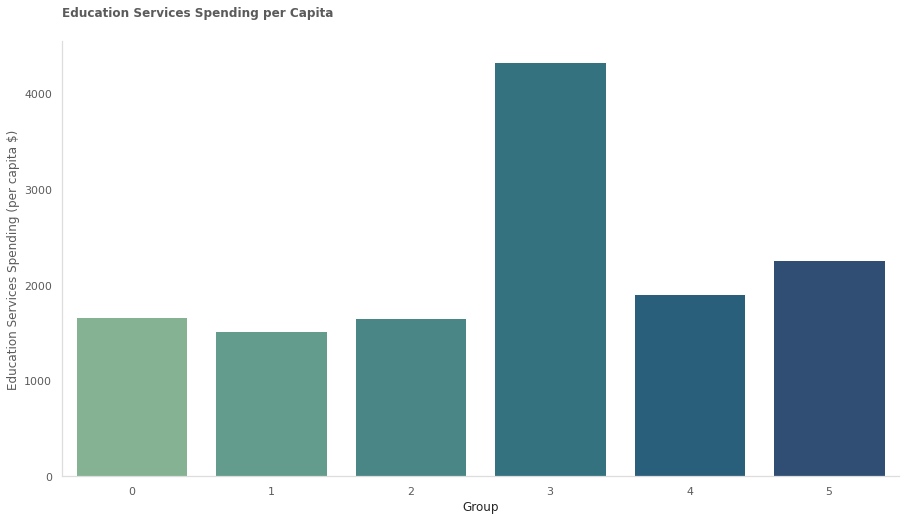

In [27]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=res,x='Group',y='education_services',palette="crest")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Education Services Spending per Capita', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Education Services Spending (per capita $)',color='#5B5B5B')

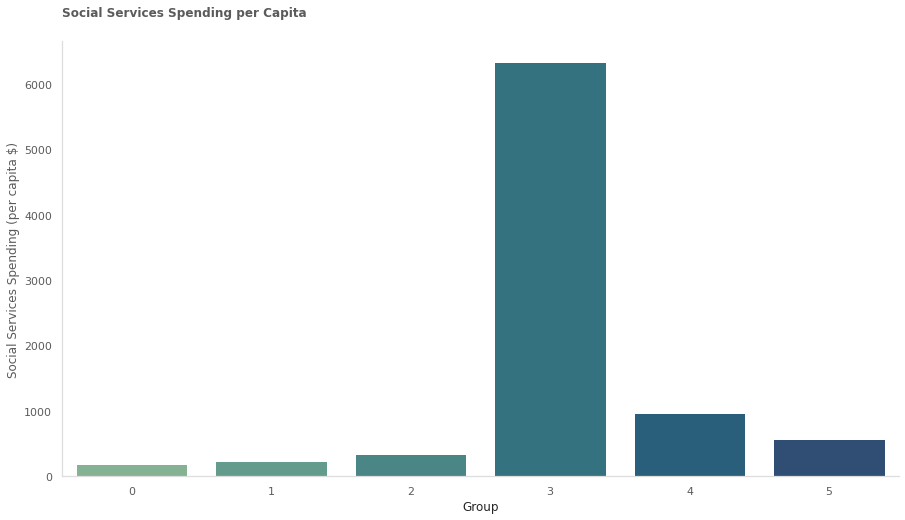

In [28]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=res,x='Group',y='social_services',palette="crest")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Social Services Spending per Capita', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Social Services Spending (per capita $)',color='#5B5B5B')

### Let's Look at Trends

In [29]:
res= test.groupby(['Year','Group']).median().reset_index().sort_values(by=['Year','violent_crime'],ascending=[True,False])
res['Year'] = pd.to_datetime(res['Year'],format="%Y")

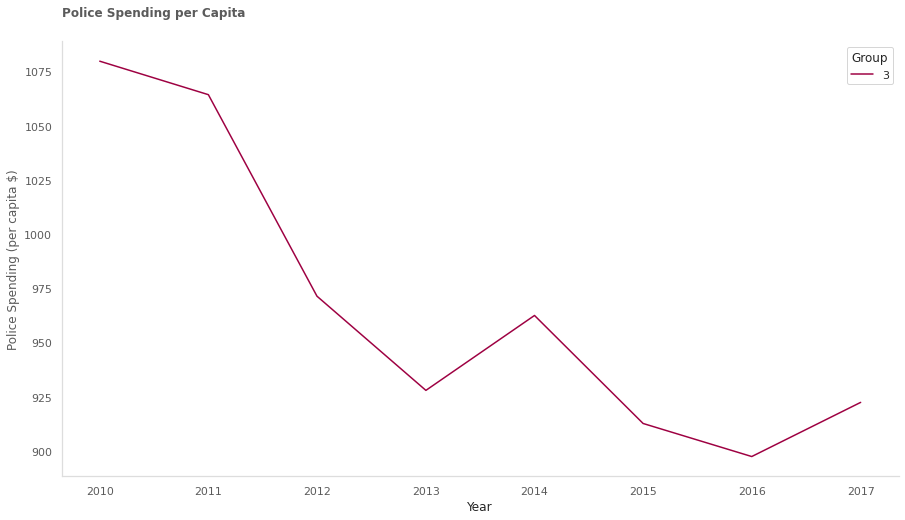

In [31]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=res[res.Group==3],x='Year',y='police',palette="Spectral",hue="Group")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Police Spending per Capita', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Police Spending (per capita $)',color='#5B5B5B')

In [ ]:
plt.figure(figsize=(25,10))
ax = sns.lineplot(data=res[res.Group.isin([1,2,4,5])],x='Year',y='police',palette="deep",hue="Group")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Police Spending per Capita', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Police Spending (per capita $)',color='#5B5B5B')
_= plt.legend(loc = 'upper left',frameon=False)

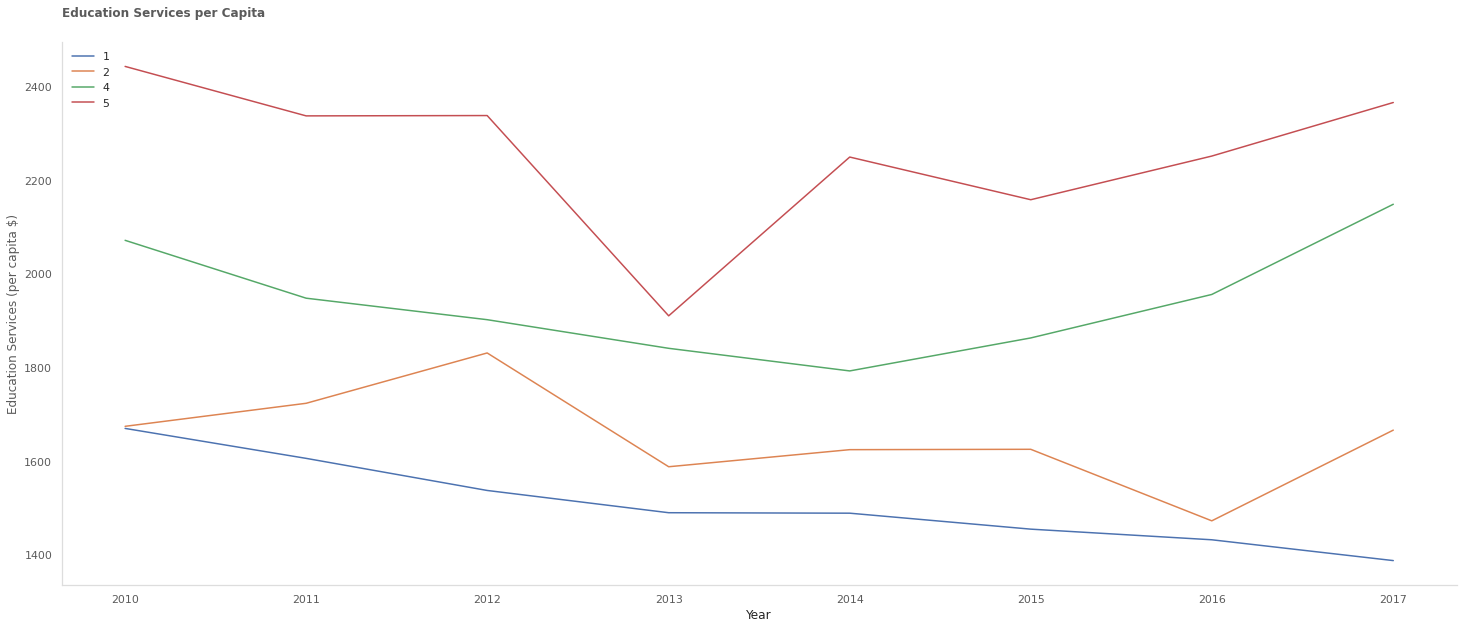

In [32]:
plt.figure(figsize=(25,10))
ax = sns.lineplot(data=res[res.Group.isin([1,2,4,5])],x='Year',y='education_services',palette="deep",hue="Group")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Education Services per Capita', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Education Services (per capita $)',color='#5B5B5B')
_= plt.legend(loc = 'upper left',frameon=False)

In [ ]:
plt.figure(figsize=(25,10))
ax = sns.lineplot(data=res[res.Group.isin([1,2,3,5])],x='Year',y='social_services',palette="deep",hue="Group")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Social Services per Capita', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Social Services (per capita $)',color='#5B5B5B')
_= plt.legend(loc = 'upper left',frameon=False)

In [ ]:
pct_changes = res[res.Group==2].copy()
pct_changes['police'] = pct_changes['police'].pct_change().fillna(0.0)
pct_changes['social_services'] = pct_changes['social_services'].pct_change().fillna(0.0)
pct_changes['education_services'] = pct_changes['education_services'].pct_change().fillna(0.0)
pct_changes['violent_crime'] = pct_changes['violent_crime'].pct_change().fillna(0.0)
pct_changes

plt.figure(figsize=(15,10))
ax = sns.lineplot(data=pct_changes,x='Year',y='social_services',palette="deep")
sns.lineplot(data=pct_changes,ax=ax,x='Year',y='police',color='r',palette="deep")
sns.lineplot(data=pct_changes,ax=ax,x='Year',y='education_services',color='g',palette="deep")
sns.lineplot(data=pct_changes,ax=ax,x='Year',y='violent_crime',color='orange',palette="deep")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B",
               grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Social Services per Capita', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
_ = ax.set_ylabel('Social Services (per capita $)',color='#5B5B5B')
_= plt.legend(labels = ['social services','police','education_services','violent_crime'],loc = 'upper left',frameon=False)

### Highest Crime Cities

In [ ]:
bygroup = res.sort_values(by='violent_crime',ascending=False)
highest_crime = int(bygroup.reset_index().loc[0]['Group'])
print("Highest Crime Group:",highest_crime)
corrs = test[test.Labels==highest_crime].corr()
sns.heatmap(corrs[abs(corrs)>0.2])

In [ ]:
ProfileReport(test[test.Group==highest_crime][list(test.columns[:5])+list(test.columns[17:18])+list(test.columns[23:34])])

### Lowest Crime Cities

In [ ]:
lowest_crime = int(bygroup.reset_index().loc[bygroup.shape[0]-2]['Group'])
lowest_crime

In [ ]:
test[test.Group==lowest_crime][list(test.columns[:5])+list(test.columns[17:18])+list(test.columns[23:34])+['total_estimate_mean_income_deficit_for_unrelated_individuals_(dollars)']].corr()

### Strongest Positive Correlations

In [43]:
violent_crime = test.groupby('Labels').median().corr()['violent_crime']
strongest_positive = list(violent_crime[violent_crime>0.50].index)
strongest_positive

['violent_crime',
 'property_crime',
 'percent_below_poverty_level_estimate_age_65_years_and_over',
 'percent_below_poverty_level_estimate_worked_full-time,_year-round_in_the_past_12_months',
 'percent_below_poverty_level_estimate_age_under_18_years',
 'percent_below_poverty_level_estimate_population_for_whom_poverty_status_is_determined',
 'percent_below_poverty_level_estimate_age_18_to_64_years']

### Strongest Negative Correlations

In [44]:
violent_crime = test.groupby('Labels').median().corr()['violent_crime']
strongest_negative = list(violent_crime[violent_crime<-0.50].index)
strongest_negative

['education_services',
 'welfare_cash',
 'housing_commdevt',
 'per_capita_personal_income_dollars',
 'personal_income_thousands_of_dollars',
 'total_estimate_employment_status_civilian_labor_force_16_years_and_over',
 'percent_race_one_race_asian']

In [74]:
test.corr()

,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,educ_elem_sec,social_services,public_welfare,...,total_estimate_age_under_18_years,total_estimate_sex_male,total_estimate_age_65_years_and_over,percent_below_poverty_level_estimate_age_18_to_64_years,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,percent_hispanic_or_latino,Labels
violent_crime,1.000000,0.504558,0.040654,0.151139,-0.082665,-0.077439,-0.143767,-0.068313,0.010782,-0.089365,...,0.150413,0.012721,-0.209692,0.258096,0.040885,0.332232,0.155468,-0.397123,0.163201,-0.283900
property_crime,0.504558,1.000000,-0.175998,-0.101946,-0.223802,-0.225287,-0.199461,-0.217228,-0.067049,-0.181555,...,0.171632,-0.088107,-0.005513,0.368339,-0.158733,0.213716,0.173096,-0.167134,0.065679,-0.065373
rev_total,0.040654,-0.175998,1.000000,0.614974,0.405987,0.396635,0.332481,0.384027,0.725488,0.687200,...,-0.132178,-0.012184,-0.286146,-0.184725,0.424479,0.128888,0.040055,-0.312987,0.065442,-0.283378
police,0.151139,-0.101946,0.614974,1.000000,0.287833,0.277034,0.234410,0.268043,0.268120,0.453404,...,-0.162295,-0.032915,-0.325071,-0.138469,0.239795,0.257093,-0.026525,-0.341693,0.070806,-0.376710
education_services,-0.082665,-0.223802,0.405987,0.287833,1.000000,0.998860,0.498011,0.995785,0.230730,0.438052,...,-0.041807,-0.040203,-0.052942,-0.247945,0.074281,-0.016892,-0.072316,-0.081810,0.003265,-0.149441
education,-0.077439,-0.225287,0.396635,0.277034,0.998860,1.000000,0.494135,0.997297,0.226834,0.427060,...,-0.035568,-0.040585,-0.051175,-0.237326,0.068785,-0.017432,-0.075584,-0.082913,0.016378,-0.147328
educ_higher,-0.143767,-0.199461,0.332481,0.234410,0.498011,0.494135,1.000000,0.428917,0.293276,0.502577,...,-0.091098,-0.084034,-0.088975,-0.110609,0.028426,0.088695,-0.123566,-0.045550,-0.103269,-0.136435
educ_elem_sec,-0.068313,-0.217228,0.384027,0.268043,0.995785,0.997297,0.428917,1.000000,0.210907,0.401264,...,-0.029257,-0.035067,-0.045654,-0.237248,0.069069,-0.025609,-0.068092,-0.082301,0.025746,-0.141551
social_services,0.010782,-0.067049,0.725488,0.268120,0.230730,0.226834,0.293276,0.210907,1.000000,0.624102,...,-0.022514,-0.076967,-0.073797,-0.016988,0.295387,0.081690,-0.004165,-0.218419,0.096844,-0.068634
public_welfare,-0.089365,-0.181555,0.687200,0.453404,0.438052,0.427060,0.502577,0.401264,0.624102,1.000000,...,-0.015085,0.028602,-0.167314,-0.152445,0.309315,0.056882,0.028069,-0.220511,0.079663,-0.000441


In [66]:
property_crime = test.groupby('Labels').mean().corr()['property_crime']
property_crime.sort_values()[abs(property_crime.sort_values())>0.75]

per_capita_personal_income_dollars                                                        -0.912255
personal_income_thousands_of_dollars                                                      -0.912255
total_estimate_employment_status_civilian_labor_force_16_years_and_over                   -0.854502
educ_elem_sec                                                                             -0.821150
percent_race_one_race_asian                                                               -0.818664
education_services                                                                        -0.817110
education                                                                                 -0.816741
housing_commdevt                                                                          -0.796756
rev_total                                                                                 -0.771341
police                                                                                    -0.763201


In [65]:
property_crime = test.groupby('Labels').median().corr()['property_crime']
property_crime.sort_values()[abs(property_crime.sort_values())>0.75]

personal_income_thousands_of_dollars                                                    -0.906607
per_capita_personal_income_dollars                                                      -0.906603
total_estimate_employment_status_civilian_labor_force_16_years_and_over                 -0.876959
total_estimate_age_18_to_64_years                                                       -0.775150
percent_race_one_race_asian                                                             -0.767462
housing_commdevt                                                                        -0.766318
educ_elem_sec                                                                           -0.756685
violent_crime                                                                            0.764710
percent_below_poverty_level_estimate_population_for_whom_poverty_status_is_determined    0.811561
percent_below_poverty_level_estimate_age_under_18_years                                  0.819656
percent_below_povert

In [67]:
violent_crime = test.groupby('Labels').median().corr()['violent_crime']
violent_crime.sort_values()[abs(violent_crime.sort_values())>0.75]

per_capita_personal_income_dollars                                                        -0.763178
personal_income_thousands_of_dollars                                                      -0.763170
percent_below_poverty_level_estimate_worked_full-time,_year-round_in_the_past_12_months    0.750587
property_crime                                                                             0.764710
percent_below_poverty_level_estimate_age_18_to_64_years                                    0.859202
percent_below_poverty_level_estimate_population_for_whom_poverty_status_is_determined      0.867415
percent_below_poverty_level_estimate_age_65_years_and_over                                 0.870910
percent_below_poverty_level_estimate_age_under_18_years                                    0.895216
violent_crime                                                                              1.000000
Name: violent_crime, dtype: float64

In [70]:
violent_crime = test.groupby('Labels').mean().corr()['violent_crime']
violent_crime.sort_values()[abs(violent_crime.sort_values())>0.70]

personal_income_thousands_of_dollars                                                      -0.706655
per_capita_personal_income_dollars                                                        -0.706655
percent_below_poverty_level_estimate_worked_full-time,_year-round_in_the_past_12_months    0.703977
property_crime                                                                             0.771015
percent_below_poverty_level_estimate_age_65_years_and_over                                 0.821121
percent_below_poverty_level_estimate_age_18_to_64_years                                    0.853507
percent_below_poverty_level_estimate_population_for_whom_poverty_status_is_determined      0.857491
percent_below_poverty_level_estimate_age_under_18_years                                    0.881422
violent_crime                                                                              1.000000
Name: violent_crime, dtype: float64

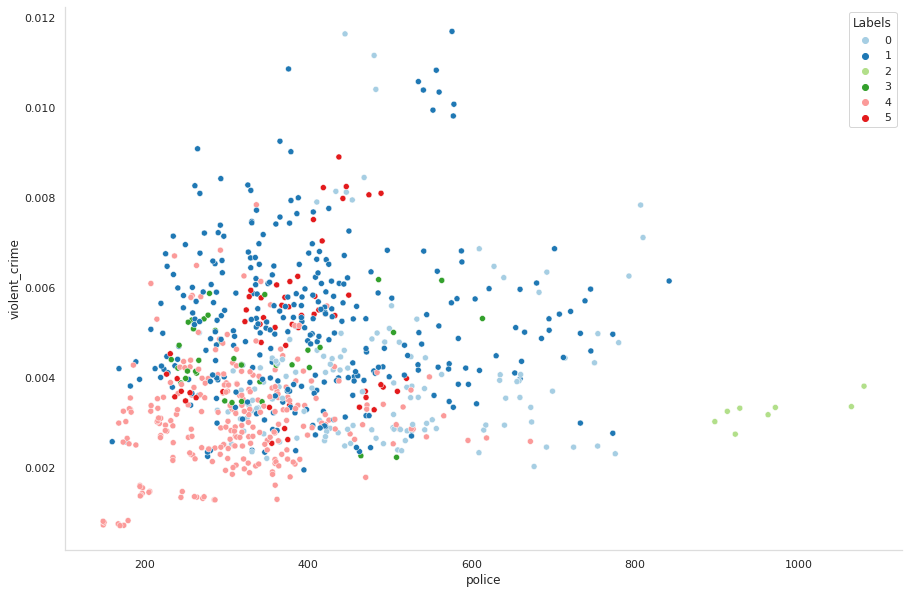

In [57]:
plt.figure(figsize=(15,10))
var = 'percent_below_poverty_level_estimate_age_under_18_years'
var = 'police'
vcrime = test[[var,'violent_crime','Labels']]
ax =sns.scatterplot(data= vcrime,x=var,y='violent_crime',hue='Labels',palette="Paired")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
sns.despine(left=False, bottom=False, right=True)

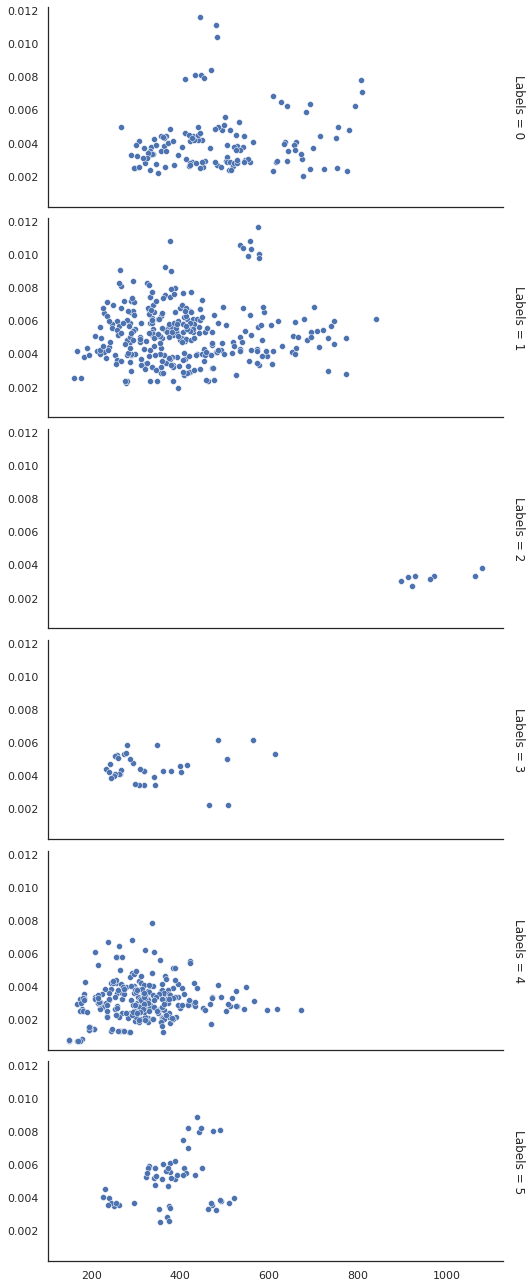

In [58]:
g = sns.FacetGrid(test,row="Labels",aspect=2.5, margin_titles=True)
g.map_dataframe(sns.scatterplot, x=var, y="violent_crime")
#g.set_axis_labels("hour", "Number of Accidents"

In [ ]:
violent_crime = test.groupby('Labels').median().corr()['violent_crime']
strongest_negative = list(violent_crime[violent_crime<-0.50].index)
strongest_negative

In [48]:
test.groupby('Labels').median().corr()['Group'].sort_values()

total_estimate_age_65_years_and_over                                                      -0.728164
percent_race_one_race_white                                                               -0.420250
property_crime                                                                            -0.335386
percent_below_poverty_level_estimate_worked_full-time,_year-round_in_the_past_12_months   -0.172974
parks_recreation                                                                          -0.056315
total_estimate_employment_status_civilian_labor_force_16_years_and_over                   -0.050287
percent_race_one_race_black_or_african_american                                           -0.008591
total_estimate_educational_attainment_population_25_years_and_over                        -0.005638
percent_below_poverty_level_estimate_age_18_to_64_years                                    0.000000
percent_below_poverty_level_estimate_population_for_whom_poverty_status_is_determined      0.029627


In [64]:
test

,city_merge_name,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,educ_elem_sec,social_services,...,total_estimate_age_65_years_and_over,percent_below_poverty_level_estimate_age_18_to_64_years,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,percent_hispanic_or_latino,Labels,Year,Group
0,"Anchorage, AK",0.008129,0.035063,6036.69,433.95,2880.31,2846.29,0.0,2846.29,103.90,...,1.825603e-07,8.6,6.5,4.9,1.7,71.1,6.7,5,2010,5
1,"Anchorage, AK",0.007892,0.033020,5815.54,410.66,2787.14,2755.34,0.0,2755.34,93.42,...,1.999156e-07,7.5,6.5,4.3,1.6,70.8,6.9,5,2011,5
2,"Anchorage, AK",0.008111,0.036182,5378.15,446.75,2429.79,2398.01,0.0,2398.01,96.70,...,2.031304e-07,7.9,7.4,5.0,1.6,70.3,7.2,5,2012,5
3,"Anchorage, AK",0.007938,0.041478,5694.68,454.03,2471.81,2439.77,0.0,2439.77,128.83,...,2.108275e-07,7.2,6.5,4.8,1.7,69.8,7.6,5,2013,5
4,"Anchorage, AK",0.008437,0.039514,5735.87,468.50,2456.47,2430.38,0.0,2430.38,81.63,...,2.261289e-07,8.5,7.4,4.5,1.7,69.3,7.9,5,2014,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,"Cheyenne, WY",0.002070,0.027459,8445.96,339.58,2471.24,2401.25,0.0,2401.25,3678.48,...,1.399698e-06,9.7,1.8,3.4,0.0,88.0,14.1,0,2013,0
874,"Cheyenne, WY",0.001600,0.024326,8430.56,359.75,2541.09,2481.71,0.0,2481.71,3337.76,...,1.472203e-06,11.8,1.0,3.3,0.0,84.9,14.3,0,2014,0
875,"Cheyenne, WY",0.001774,0.025819,8849.32,470.45,2767.05,2703.34,0.0,2703.34,3448.83,...,1.434651e-06,11.0,1.2,2.5,0.2,88.7,14.5,0,2015,0
876,"Cheyenne, WY",0.002519,0.030213,8710.69,504.08,2665.20,2599.29,0.0,2599.29,3753.47,...,1.491359e-06,9.8,1.2,2.7,0.4,90.6,14.6,0,2016,0


In [77]:
test[test.Group==2][test.columns[:-1]].drop(columns='Labels').corr()['violent_crime'].sort_values()

total_estimate_age_65_years_and_over                                                      -0.651666
police                                                                                    -0.521048
housing_commdevt                                                                          -0.460142
percent_below_poverty_level_estimate_age_under_18_years                                   -0.362894
percent_below_poverty_level_estimate_population_for_whom_poverty_status_is_determined     -0.359867
percent_below_poverty_level_estimate_age_18_to_64_years                                   -0.359119
rev_total                                                                                 -0.350695
social_services                                                                           -0.337559
percent_below_poverty_level_estimate_age_65_years_and_over                                -0.286231
percent_below_poverty_level_estimate_worked_full-time,_year-round_in_the_past_12_months   -0.256511


In [83]:
group2 = test[test.Group==2]
group2[group2.Year==2017]

,city_merge_name,violent_crime,property_crime,rev_total,police,education_services,education,educ_higher,educ_elem_sec,social_services,...,total_estimate_age_65_years_and_over,percent_below_poverty_level_estimate_age_18_to_64_years,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,percent_hispanic_or_latino,Labels,Year,Group
284,"Indianapolis, IN",0.006945,0.028824,5538.46,249.89,1738.53,1686.78,0.00,1686.78,1407.03,...,6.394401e-08,11.1,3.1,15.1,0.0,77.4,6.8,1,2017,2
359,"Worcester, MA",0.003602,0.013443,5045.36,257.73,2289.82,2256.90,0.00,2256.90,29.52,...,1.573519e-07,10.4,4.5,4.7,0.0,84.0,11.5,0,2017,2
406,"Grand Rapids, MI",0.003240,0.015166,4824.34,321.93,1274.89,1195.40,0.00,1195.40,325.28,...,1.286731e-07,9.7,2.6,6.3,0.0,84.5,9.5,0,2017,2
435,"Gulfport, MS",0.002376,0.038673,10821.43,331.51,1561.28,1545.85,0.00,1545.85,6746.82,...,3.578475e-07,15.4,2.4,22.3,0.1,71.5,5.6,1,2017,2
442,"Jackson, MS",0.003377,0.024400,3808.94,256.32,1679.33,1660.02,0.00,1660.02,84.06,...,2.211536e-07,14.0,1.1,49.8,0.0,47.1,2.4,1,2017,2
461,"Charlotte, NC",0.004162,0.028004,8526.80,430.67,1653.29,1619.91,176.09,1443.82,3023.47,...,5.079268e-08,11.0,3.7,22.6,0.1,67.1,10.2,5,2017,2


<AxesSubplot:xlabel='city_merge_name', ylabel='per_capita_personal_income_dollars'>

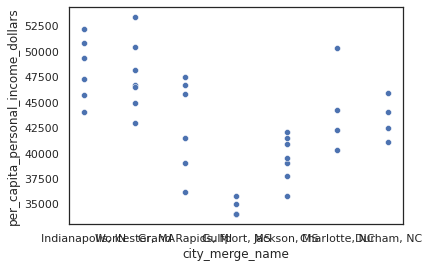

In [81]:
sns.scatterplot(data=test[test.Group==2],x='city_merge_name',y='per_capita_personal_income_dollars')

In [ ]:
relevant_columns = test[['city_merge_name','Year']+strongest_positive+strongest_negative+['Labels']]

In [ ]:
ProfileReport(relevant_columns)

In [ ]:
ProfileReport(test[test.Group==lowest_crime][list(test.columns[:5])+list(test.columns[17:18])+list(test.columns[23:34])])

In [ ]:
res= test.groupby(['Group','Year']).mean().reset_index().sort_values(by=["Year","Group"])
res.head()

In [ ]:
plt.figure(figsize=(15,8))


ax = sns.lineplot(data = res, x='Year',y='violent_crime',hue="Group",palette="deep")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B")
               #grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Violent Crime Over Time', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
ax.set_ylabel('Violent Crime Rate (Per Capita)',color='#5B5B5B')

In [ ]:
test.columns

In [ ]:
plt.figure(figsize=(15,8))


ax = sns.lineplot(data = res, x='Year',y='violent_crime',hue="Group",palette="deep")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
ax.tick_params(direction='out', length=6, width=2, colors="#5B5B5B")
               #grid_color='r', grid_alpha=0.5)
_ = ax.set_title('Violent Crime Over Time', color='#5B5B5B',loc='left',pad=25.0,fontweight="bold")
ax.set_ylabel('Violent Crime Rate (Per Capita)',color='#5B5B5B')

### Save Data

In [ ]:
merged_df3.to_csv('CleanData/CompleteMerged.csv',index=False)